## Install Earth Engine API and geemap
Install the [Earth Engine Python API](https://developers.google.com/earth-engine/python_install) and [geemap](https://geemap.org). The **geemap** Python package is built upon the [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) and [folium](https://github.com/python-visualization/folium) packages and implements several methods for interacting with Earth Engine data layers, such as `Map.addLayer()`, `Map.setCenter()`, and `Map.centerObject()`.
The following script checks if the geemap package has been installed. If not, it will install geemap, which automatically installs its [dependencies](https://github.com/giswqs/geemap#dependencies), including earthengine-api, folium, and ipyleaflet.

In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [3]:
import ee
import geemap
import pprint

# ee.Authenticate()
ee.Initialize()

## Create an interactive map 
The default basemap is `Google Maps`. [Additional basemaps](https://github.com/giswqs/geemap/blob/master/geemap/basemaps.py) can be added using the `Map.add_basemap()` function. 

In [7]:
import sys
sys.path.insert(0, "./lst_cam_modules")

import os
os.environ['PROJ_LIB'] = r'/mnt/lustre/a2fs-work3/work/e283/e283/leitm/yhe/venv/miniconda3/envs/jupyter-gee/share/proj'

from lst_cam_modules import utils, Landsat_LST

# geometry = utils.getGeometry('users/yhephd/coords/coord_cambridge')

# geo_shp = './data/cambridge/shp/cambridge_district.shp'
geo_shp = './data/cambridge/shp/cambridge_wards.shp'
geometry = geemap.shp_to_ee(geo_shp)

satellite = 'L8'
date_start = '2019-12-01'
date_end = '2019-12-31'
use_ndvi = True
use_cloudmask = False
cloudlimit = 25

# get landsat collection with added variables: NDVI, FVC, TPW, EM, LST
LandsatColl = Landsat_LST.collection(satellite, date_start, date_end, geometry, use_ndvi, use_cloudmask, cloudlimit)

pp = pprint.PrettyPrinter(depth=3)
pp.pprint(LandsatColl.getInfo())

{'bands': [],
 'features': [{'bands': [...],
               'id': 'LANDSAT/LC08/C01/T1_SR/LC08_201024_20191209',
               'properties': {...},
               'type': 'Image',
               'version': 1577007323417271}],
 'type': 'ImageCollection'}


In [8]:
Map = geemap.Map()
Map.centerObject(geometry, 13)

visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}
Map.addLayer(LandsatColl, visParams, 'RGB_col', 0)

# select the first feature
# exImage = LandsatColl.first()
listOfImages = LandsatColl.toList(LandsatColl.size())
exImage = ee.Image(listOfImages.get(0))
Map.addLayer(exImage, visParams, 'RGB_img', 1)

pp = pprint.PrettyPrinter(depth=1)
pp.pprint(exImage.getInfo())
# Map

{'bands': [...],
 'id': 'LANDSAT/LC08/C01/T1_SR/LC08_201024_20191209',
 'properties': {...},
 'type': 'Image',
 'version': 1577007323417271}


In [10]:
exImage = utils.maskInside(exImage, geometry)

cmap1 = ['blue', 'cyan', 'green', 'yellow', 'red']
cmap2 = ['F2F2F2','EFC2B3','ECB176','E9BD3A','E6E600','63C600','00A600']

Map.addLayer(exImage.multiply(0.0001),{'bands': ['B4',  'B3',  'B2'], 'min':0, 'max':0.3}, 'RGB', 1)
Map.addLayer(exImage.select('TPW'),{'min':0.0, 'max':60.0, 'palette':cmap1},'TCWV', 0)
Map.addLayer(exImage.select('TPWpos'),{'min':0.0, 'max':9.0, 'palette':cmap1},'TCWVpos', 0)
Map.addLayer(exImage.select('NDVI'),{'min':-1.0, 'max':1.0, 'palette':cmap2}, 'NDVI', 0)
Map.addLayer(exImage.select('FVC'),{'min':0.0, 'max':1.0, 'palette':cmap2}, 'FVC', 0)
Map.addLayer(exImage.select('EM'),{'min':0.9, 'max':1.0, 'palette':cmap1}, 'Emissivity', 0)
Map.addLayer(exImage.select('B10'),{'min':277.7080505371094, 'max':287.25209350585936, 'palette':cmap1}, 'TIR BT', 0)
Map.addLayer(exImage.select('LST'),{'min':-0.008242821473221501, 'max':8.999065923443641, 'palette':cmap1}, 'LST', 1)

Map.addLayer(geometry, {}, 'geometry', 1, 0.5)
Map

Map(bottom=691130.0, center=[52.199368594649954, 0.13292313451525142], controls=(WidgetControl(options=['posit…

In [11]:
pp = pprint.PrettyPrinter(depth=1)

vmin = ee.Number(exImage.select('LST').reduceRegion(
    reducer = ee.Reducer.min(), 
    geometry = geometry, 
    scale = 30, 
    maxPixels = 1e9 
).values().get(0))
pp.pprint('minLST: '+str(vmin.getInfo()))

vmax = ee.Number(exImage.select('LST').reduceRegion(
    reducer = ee.Reducer.max(),
    geometry = geometry,
    scale = 30,
    maxPixels = 1e9
).values().get(0))
pp.pprint('maxLST: '+str(vmax.getInfo()))

'minLST: -2.254867007336543'
'maxLST: 10.021135708978363'


In [15]:
# Export the image, specifying scale and region.

task = ee.batch.Export.image.toDrive(**{
  'image': exImage.select(['LST']),
  'description': 'LST_20191209_30m',
  'folder': 'Todo',
  'scale': 30,
  'region': geometry,
  'fileFormat': 'GeoTIFF',
  'crs': 'EPSG:5070',
  'maxPixels': 1e13
})

In [13]:
task.start()
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: 5LOY2BKEHKM74PGFTGC3PJPC).


In [12]:
states_shp = './data/cambridge/shp/cambridge_wards.shp'
states = geemap.shp_to_ee(states_shp)

geemap.ee_export_vector(states, filename='./outputs/cambridge/cambridge_wards.csv')

Map.addLayer(states, {}, 'cambridge_wards')
Map

Generating URL ...
Please wait ...
Data downloaded to /mnt/lustre/a2fs-work3/work/e283/e283/leitm/yhe/github/google-earth-engine/gee-maps-cam/outputs/cambridge/cambridge_wards.csv


Map(bottom=691130.0, center=[52.199368594649954, 0.13292313451525142], controls=(WidgetControl(options=['posit…

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,EPC_kWh_m2,count,epc_save,geometry
0,Trumpington,DIW,District Ward,CAMBRIDGESHIRE_COUNTY,5939,5939,139620,179865,E05013062,619.711,0.0,VA,CIVIL VOTING AREA,None,None,159,160,25,"POLYGON ((544728.897 257284.502, 544738.799 25..."
1,Newnham,DIW,District Ward,CAMBRIDGESHIRE_COUNTY,5940,5940,139621,179866,E05013058,485.347,0.0,VA,CIVIL VOTING AREA,None,None,263,82,34,"POLYGON ((541592.302 259454.101, 541747.796 25..."


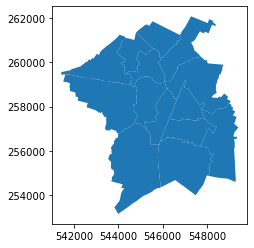

In [13]:
# Import necessary modules
import geopandas as gpd

# Set filepath
states_shp = './data/cambridge/shp/cambridge_wards.shp'

# Read file using gpd.read_file()
data = gpd.read_file(states_shp)
# type(data)
data.plot()
data.head(2)